# Revamp Emission Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import astropy.units as u
import astropy.constants as const
from astropy.utils.console import ProgressBar
import fiasco

from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import EmissionModel#, Element, list_elements

%matplotlib inline

In [16]:
temperature = 10.**(np.arange(4.5,8,0.05))*u.K
density = np.logspace(7,11,10)/(u.cm**3)

In [17]:
selected_elements = [
                     'calcium',
                     'iron',
                     'magnesium',
                     'nickel',
                     'oxygen',
                     'silicon',
                     'sulfur'
]
elements = [fiasco.Element(el,temperature,abundance_filename='sun_coronal_1992_feldman') for el in selected_elements]

In [18]:
collection = EmissionModel(density,*elements)

In [19]:
#collection.calculate_emissivity('/Users/willbarnes/Desktop/emissivity_test.h5')
collection.emissivity_savefile = '/Users/willbarnes/Desktop/emissivity_test.h5'

In [20]:
aia = InstrumentSDOAIA([0,1]*u.s)

In [21]:
calc_temp_response = {c['name']: None for c in aia.channels}
with ProgressBar(len(aia.channels)*len(collection._ion_list),ipython_widget=True,) as prog:
    for ion in collection:
        wvl,em = collection.get_emissivity(ion)
        if wvl is None or em is None:
            continue
        #upper_level = ion.transitions.upper_level[~ion.transitions.is_twophoton]
        #w = ion.transitions.wavelength[~ion.transitions.is_twophoton]
        #A = ion.transitions.A[~ion.transitions.is_twophoton]
        #i_upper = fiasco.util.vectorize_where(ion._elvlc['level'], upper_level)
        #g = pop[:,:,i_upper] * A
        #g = g[:,:,np.argsort(w)]
        #w = np.sort(w)
        for channel in aia.channels:
            response = scipy.interpolate.splev(wvl.value, channel['wavelength_response_spline'])
            response = np.where(response < 0., 0., response)
            tmp = np.dot(em.value, response)
            ab = ion.abundance.value
            tmp *= ab*ion.ioneq.value[:,np.newaxis]/density.value/4./np.pi
            #if ion.element_name in components:
            #    components[ion.element_name] += tmp
            #else:
            #    components[ion.element_name] = tmp
            if calc_temp_response[channel['name']] is None:
                calc_temp_response[channel['name']] = tmp
            else:
                calc_temp_response[channel['name']] += tmp
            #calc_temp_response[f'{channel["name"]}_components'] = components
            prog.update()

FloatProgress(value=0.0)

In [22]:
const_p_indices = np.array([(i,np.argmin(np.fabs(density.value-d.value))) 
                            for i,d in enumerate(1e15/temperature)])

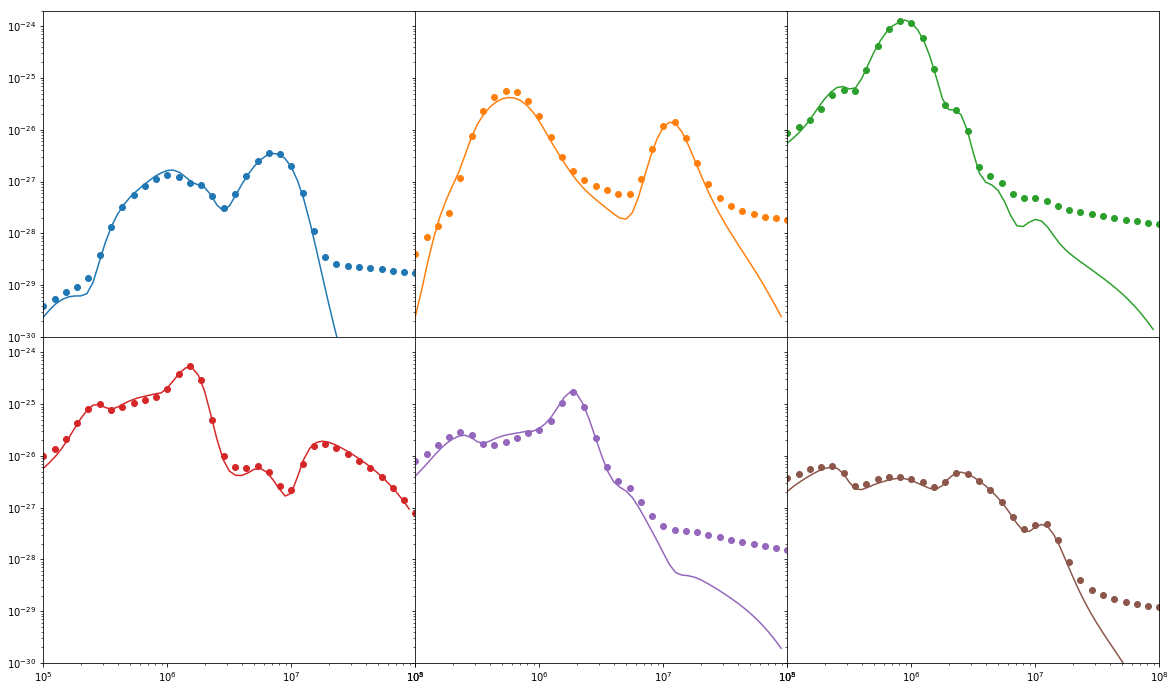

In [23]:
fig,axes = plt.subplots(2,3,figsize=(20,12),sharex=True,sharey=True)
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(data_temperature,channel['temperature_response_spline'])
    ax.plot(data_temperature,real_response,'o',markevery=3,color=f'C{i}')
    ax.plot(temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],color=f'C{i}',ls='-')
    #for j,element in enumerate(calc_temp_response[f'{channel["name"]}_components']):
    #    ax.plot(temperature,
    #            calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
    #          color=f'C{j%10}',ls='--',label=element)
    #if i==0:
    #    ax.legend()
    #ax.text(2e5,3e-25,f'{channel["name"]}',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)